In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
import string
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.metrics import classification_report
import pickle

In [2]:
from transformers import AutoTokenizer,TFBertModel
tokenizer=AutoTokenizer.from_pretrained('bert-base-cased')
bert=TFBertModel.from_pretrained('bert-base-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [4]:
df=pd.read_csv('/kaggle/input/symptom2disease/Symptom2Disease.csv')

In [5]:
df

,Unnamed: 0,label,text
0,0,Psoriasis,I have been experiencing a skin rash on my arm...
1,1,Psoriasis,"My skin has been peeling, especially on my kne..."
2,2,Psoriasis,I have been experiencing joint pain in my fing...
3,3,Psoriasis,"There is a silver like dusting on my skin, esp..."
4,4,Psoriasis,"My nails have small dents or pits in them, and..."
...,...,...,...
1195,295,diabetes,I'm shaking and trembling all over. I've lost ...
1196,296,diabetes,"Particularly in the crevices of my skin, I hav..."
1197,297,diabetes,I regularly experience these intense urges and...
1198,298,diabetes,"I have trouble breathing, especially outside. ..."


<Axes: xlabel='label'>

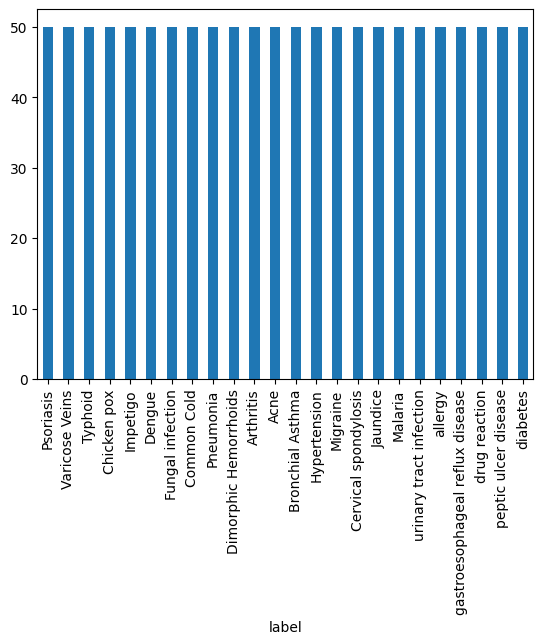

In [6]:
df['label'].value_counts().plot(kind='bar')

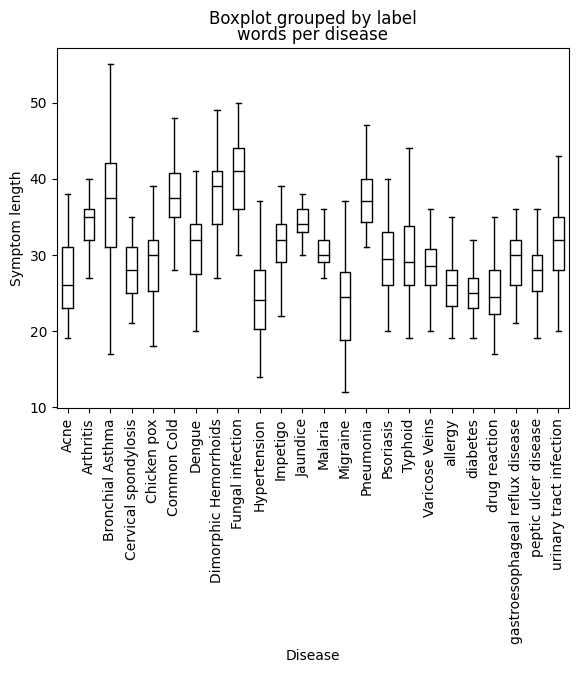

In [7]:
df['words per disease']=df['text'].str.split().apply(len)
df.boxplot('words per disease',by='label',grid=False,showfliers=False,color='black')
plt.xticks(rotation=90)
plt.xlabel('Disease')
plt.ylabel('Symptom length')
plt.show()

In [8]:
max(df['words per disease'].values)

55

In [9]:
def preprocess_text(text):
    text=text.lower()
    text=text.translate(str.maketrans('','',string.punctuation))
    return text

In [10]:
df['preprocessed text']=df['text'].apply(preprocess_text)

In [11]:
df['preprocessed text']

0       i have been experiencing a skin rash on my arm...
1       my skin has been peeling especially on my knee...
2       i have been experiencing joint pain in my fing...
3       there is a silver like dusting on my skin espe...
4       my nails have small dents or pits in them and ...
                              ...                        
1195    im shaking and trembling all over ive lost my ...
1196    particularly in the crevices of my skin i have...
1197    i regularly experience these intense urges and...
1198    i have trouble breathing especially outside i ...
1199    i constantly sneeze and have a dry cough my in...
Name: preprocessed text, Length: 1200, dtype: object

In [12]:
le=LabelEncoder()
df['disease']=le.fit_transform(df['label'])
print(le.classes_)
print()

['Acne' 'Arthritis' 'Bronchial Asthma' 'Cervical spondylosis'
 'Chicken pox' 'Common Cold' 'Dengue' 'Dimorphic Hemorrhoids'
 'Fungal infection' 'Hypertension' 'Impetigo' 'Jaundice' 'Malaria'
 'Migraine' 'Pneumonia' 'Psoriasis' 'Typhoid' 'Varicose Veins' 'allergy'
 'diabetes' 'drug reaction' 'gastroesophageal reflux disease'
 'peptic ulcer disease' 'urinary tract infection']



In [13]:
X_train,X_test,y_train,y_test=train_test_split(df['preprocessed text'],df['disease'],test_size=0.1,stratify=df['disease'])

In [14]:
print(f"Training set: {X_train.shape}:  {y_train.shape}")
print(f"Testing set: {X_test.shape}: {y_test.shape}")

Training set: (1080,):  (1080,)
Testing set: (120,): (120,)


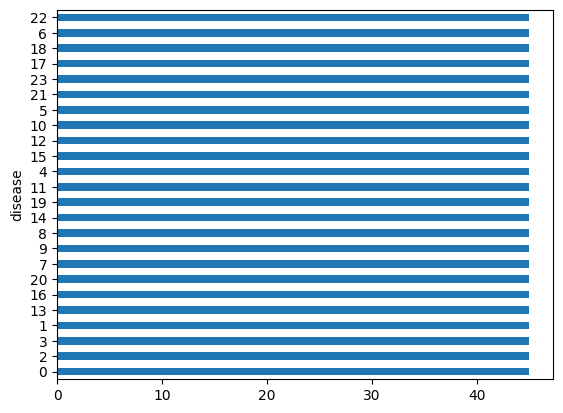

<Axes: ylabel='disease'>

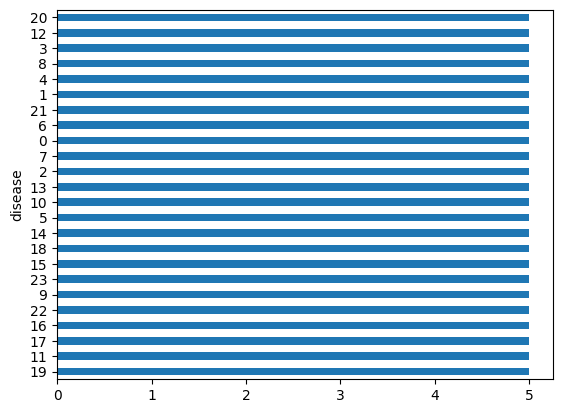

In [15]:
y_train.value_counts().plot(kind='barh')
plt.show()
y_test.value_counts().plot(kind='barh')

In [16]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [17]:
x_train=tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=55,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [18]:
x_test=tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length=55,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [48]:
input_ids=tf.keras.layers.Input(shape=(55,),name='input_ids',dtype=tf.int32)
input_mask=tf.keras.layers.Input(shape=(55,),name='attention_mask',dtype=tf.int32)
embeddings=bert(input_ids,input_mask)[0]
output=tf.keras.layers.GlobalAveragePooling1D()(embeddings)
output=tf.keras.layers.Dense(64,activation='relu')(output)
# output=tf.keras.layers.Dropout(0.5)(output)
output=tf.keras.layers.Dense(32,activation='relu')(output)
# output=tf.keras.layers.Dropout(0.5)(output)
y=tf.keras.layers.Dense(24,activation='softmax')(output)
model=tf.keras.models.Model(inputs=[input_ids,input_mask],outputs=y)
model.layers[2].trainable=True

In [49]:
optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5,epsilon=1e-08,clipnorm=1.0)

In [50]:
loss=tf.keras.losses.SparseCategoricalCrossentropy()

In [51]:
model.compile(metrics=['accuracy'],loss=loss,optimizer=optimizer)

In [52]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 55)]                 0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 55)]                 0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1083102   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   72         'attention_mask[0][0]']      
                             hidden_state=(None, 55, 76                                     

In [53]:
history=model.fit(
     x = {'input_ids':x_train['input_ids'], 'attention_mask':x_train['attention_mask']},
    y=y_train,
    validation_data = ({'input_ids':x_test['input_ids'], 'attention_mask':x_test['attention_mask']},
                        y_test),
    epochs=5,
#     batch_size=32
)

Epoch 1/5
34/34 [==============================] - 87s 625ms/step - loss: 1.1801 - accuracy: 0.7491 - val_loss: 0.3026 - val_accuracy: 0.9583
Epoch 2/5
34/34 [==============================] - 9s 267ms/step - loss: 0.1219 - accuracy: 0.9944 - val_loss: 0.1508 - val_accuracy: 0.9583
Epoch 3/5
34/34 [==============================] - 9s 253ms/step - loss: 0.0418 - accuracy: 0.9991 - val_loss: 0.2077 - val_accuracy: 0.9667
Epoch 4/5
34/34 [==============================] - 9s 256ms/step - loss: 0.0459 - accuracy: 0.9963 - val_loss: 0.0663 - val_accuracy: 0.9833
Epoch 5/5
34/34 [==============================] - 8s 245ms/step - loss: 0.0162 - accuracy: 1.0000 - val_loss: 0.0366 - val_accuracy: 0.9917


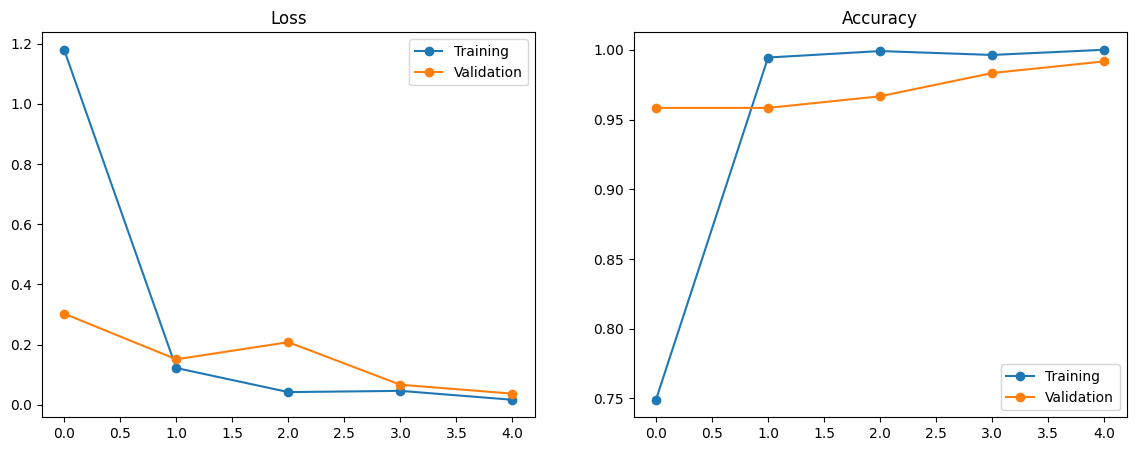

In [54]:
plt.figure(figsize = (14, 5))

plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], marker = 'o', label = 'Training')
plt.plot(history.history['val_loss'], marker='o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], marker = 'o', label = 'Training')
plt.plot(history.history['val_accuracy'], marker='o', label = 'Validation')
plt.legend()

In [59]:
probs=model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})

4/4 [==============================] - 0s 82ms/step


In [63]:
predicted_class=np.argmax(probs,axis=1)
target_names = le.classes_
print(classification_report(y_test, predicted_class, target_names=target_names))

                                 precision    recall  f1-score   support

                           Acne       1.00      1.00      1.00         5
                      Arthritis       1.00      1.00      1.00         5
               Bronchial Asthma       1.00      1.00      1.00         5
           Cervical spondylosis       1.00      1.00      1.00         5
                    Chicken pox       1.00      1.00      1.00         5
                    Common Cold       1.00      1.00      1.00         5
                         Dengue       1.00      1.00      1.00         5
          Dimorphic Hemorrhoids       1.00      1.00      1.00         5
               Fungal infection       1.00      1.00      1.00         5
                   Hypertension       1.00      1.00      1.00         5
                       Impetigo       1.00      1.00      1.00         5
                       Jaundice       1.00      1.00      1.00         5
                        Malaria       1.00      1.

In [66]:
test1=tokenizer(
    text="Pain in the  knee",
    add_special_tokens=True,
    max_length=55,
    truncation=True,
    padding='max_length',
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)
predictions=model.predict({'input_ids': test1['input_ids'], 'attention_mask': test1['attention_mask']})

1/1 [==============================] - 0s 39ms/step


In [67]:
predicted_class=np.argmax(predictions)
print(le.inverse_transform([predicted_class]))

['Varicose Veins']


In [65]:
model.save('symptoms.h5')

/opt/conda/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [80]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump({'tokenizer':tokenizer,'label_encoder':le}, handle, protocol=pickle.HIGHEST_PROTOCOL)